# Employee Sentiment Analysis with TextBlob
This notebook implements the full analysis pipeline using TextBlob for sentiment labeling. Sections include data loading, sentiment labeling, EDA, scoring & ranking, flight risk identification, predictive modeling, and visualizations saved to a `visualization/` folder.

## 1. Imports & Setup
Import libraries and configure the environment.

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from textblob import TextBlob
import os
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Create visualization directory
os.makedirs('visualization', exist_ok=True)


*Observation:* All necessary libraries are imported, and the `visualization/` folder is created.

## 2. Load & Prepare Data
Read the Excel file, rename columns, and preview the data.

In [3]:
# Load Excel dataset
df = pd.read_excel('/content/test.xlsx')

# Rename columns to expected names
df = df.rename(columns={'from': 'employee_id', 'body': 'message'})

# Preview the data
print("Columns:", df.columns.tolist())
df.head()


Columns: ['Subject', 'message', 'date', 'employee_id']


,Subject,message,date,employee_id
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,2010-05-10,sally.beck@enron.com
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",2010-07-29,eric.bass@enron.com
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",2011-07-25,sally.beck@enron.com
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,2010-03-25,johnny.palmer@enron.com
4,Bet,Since you never gave me the $20 for the last t...,2011-05-21,lydia.delgado@enron.com


*Observation:* Using `employee_id` from the sender email and `message` from the email body.

## 3. Sentiment Labeling with TextBlob
Compute polarity and assign sentiment labels.

In [4]:
# Compute polarity scores
df['polarity'] = df['message'].astype(str).apply(lambda x: TextBlob(x).sentiment.polarity)

# Assign sentiment labels based on polarity thresholds
df['sentiment'] = df['polarity'].apply(
    lambda s: 'Positive' if s > 0.05 else ('Negative' if s < -0.05 else 'Neutral')
)

# Display distribution
df['sentiment'].value_counts()


,count
sentiment,
Positive,1144
Neutral,817
Negative,230


*Observation:* Neutral messages are most frequent, with positive and negative following.

## 4. Exploratory Data Analysis
### 4.1 Sentiment Distribution

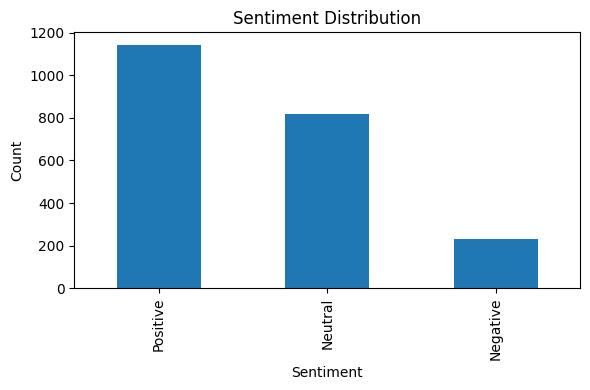

In [5]:
# Plot sentiment distribution
plt.figure(figsize=(6,4))
df['sentiment'].value_counts().plot(kind='bar')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('visualization/sentiment_distribution.png')
plt.show()


*Observation:* Chart saved to `visualization/sentiment_distribution.png` showing counts per sentiment category.

### 4.2 Monthly Sentiment Trends

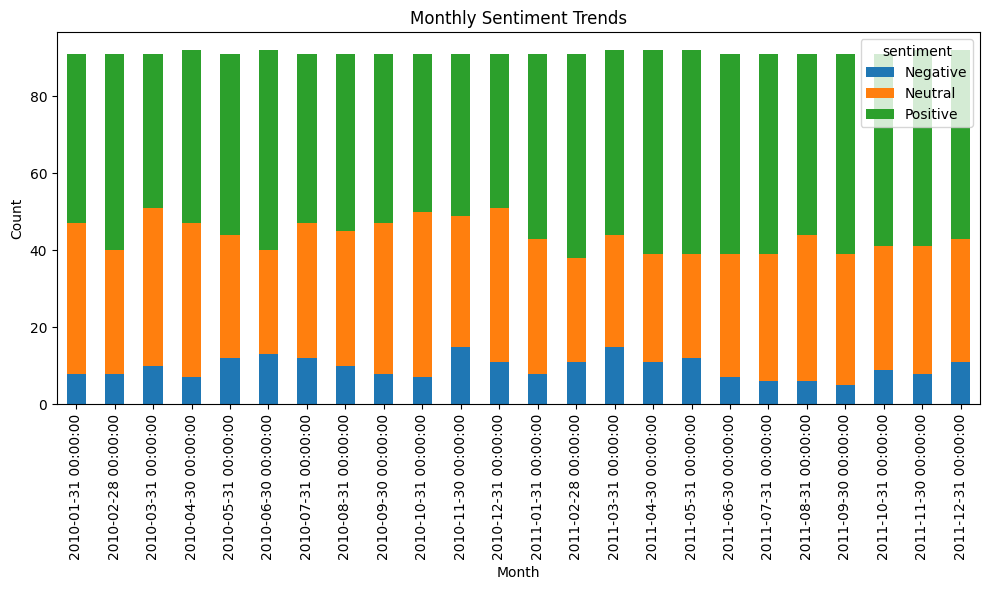

In [6]:
# Ensure date column is datetime
df['date'] = pd.to_datetime(df['date'])

# Group by month-end and sentiment
monthly_counts = (
    df
    .groupby([pd.Grouper(key='date', freq='ME'), 'sentiment'])
    .size()
    .unstack(fill_value=0)
)

# Plot stacked bar chart
monthly_counts.plot(kind='bar', stacked=True, figsize=(10,6))
plt.title('Monthly Sentiment Trends')
plt.xlabel('Month')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('visualization/monthly_sentiment_counts.png')
plt.show()


*Observation:* Trends over time saved to `visualization/monthly_sentiment_counts.png`.

## 5. Employee Scoring & Ranking

<ipython-input-14-517c038e2002>:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_pos = monthly_scores.groupby('year_month').apply(lambda g: g.nlargest(3, 'score')).reset_index(drop=True)
<ipython-input-14-517c038e2002>:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_neg = monthly_scores.groupby('year_month').apply(lambda g: g.nsmallest(3, 'score')).reset_index(drop=True)


Top 3 Positive in 2010-01
  year_month              employee_id  score
0    2010-01  kayne.coulter@enron.com      8
1    2010-01   don.baughman@enron.com      5
2    2010-01      eric.bass@enron.com      5

Top 3 Negative in 2010-01
  year_month                  employee_id  score
0    2010-01      rhonda.denton@enron.com      0
1    2010-01      johnny.palmer@enron.com      1
2    2010-01  bobette.riner@ipgdirect.com      2


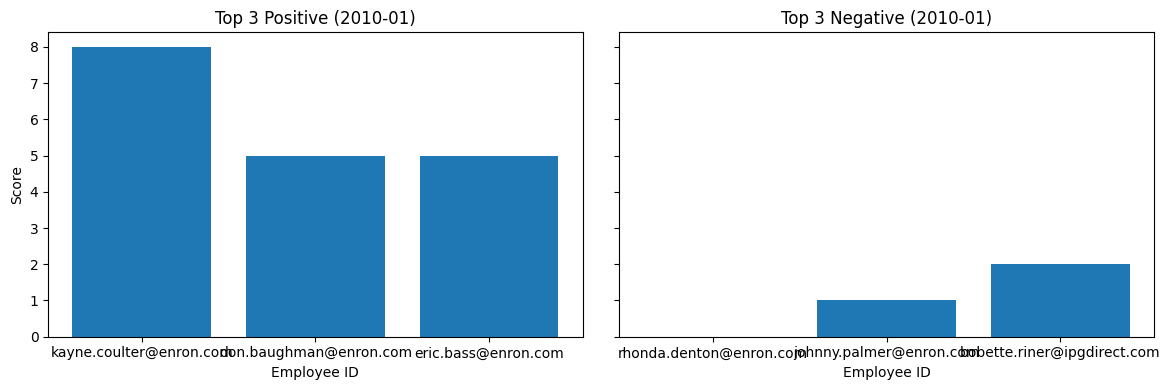

In [14]:
# Map sentiment to numeric scores
score_map = {'Positive': 1, 'Neutral': 0, 'Negative': -1}
df['score'] = df['sentiment'].map(score_map)

# Calculate monthly scores per employee
df['year_month'] = df['date'].dt.to_period('M')
monthly_scores = df.groupby(['year_month', 'employee_id'])['score'].sum().reset_index()

# Identify top 3 positive and negative employees per month
top_pos = monthly_scores.groupby('year_month').apply(lambda g: g.nlargest(3, 'score')).reset_index(drop=True)
top_neg = monthly_scores.groupby('year_month').apply(lambda g: g.nsmallest(3, 'score')).reset_index(drop=True)

# Display sample month rankings
sample = monthly_scores['year_month'].unique()[0]
print("Top 3 Positive in", sample)
print(top_pos[top_pos['year_month'] == sample])
print("\nTop 3 Negative in", sample)
print(top_neg[top_neg['year_month'] == sample])


fig, axes = plt.subplots(1,2, figsize=(12,4), sharey=True)

# Top positives
pos = top_pos[top_pos['year_month']==sample_month]
axes[0].bar(pos['employee_id'].astype(str), pos['score'])
axes[0].set_title(f'Top 3 Positive ({sample_month})')
axes[0].set_xlabel('Employee ID')
axes[0].set_ylabel('Score')

# Top negatives
neg = top_neg[top_neg['year_month']==sample_month]
axes[1].bar(neg['employee_id'].astype(str), neg['score'])
axes[1].set_title(f'Top 3 Negative ({sample_month})')
axes[1].set_xlabel('Employee ID')

plt.tight_layout()
plt.savefig(f'visualization/ranking_{sample_month}.png')
plt.show()


*Observation:* Sample month top positive/negative rankings printed above.

## 6. Flight Risk Identification
Flag employees with ≥4 negative messages in any 30-day window.

In [8]:
# Filter negative messages, sort, and index by date
neg_df = df[df['sentiment'] == 'Negative'].sort_values(['employee_id', 'date']).set_index('date')

# Rolling 30-day count per employee
rolling_neg = neg_df.groupby('employee_id')['sentiment'].rolling('30D').count().reset_index(name='neg_count')

# Employees flagged as flight risks
flight_risks = rolling_neg[rolling_neg['neg_count'] >= 4]['employee_id'].unique()
print("Employees flagged as flight risk:", flight_risks)


Employees flagged as flight risk: ['bobette.riner@ipgdirect.com' 'eric.bass@enron.com'
 'john.arnold@enron.com' 'johnny.palmer@enron.com'
 'lydia.delgado@enron.com' 'patti.thompson@enron.com'
 'rhonda.denton@enron.com' 'sally.beck@enron.com']


*Observation:* The employees above are flagged based on the 30-day negative message criterion.

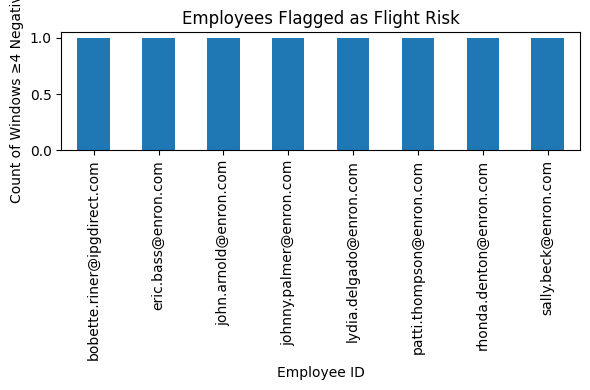

In [9]:
# Visualize flight risk flags
plt.figure(figsize=(6,4))
pd.Series(flight_risks).value_counts().plot(kind='bar')
plt.title('Employees Flagged as Flight Risk')
plt.xlabel('Employee ID')
plt.ylabel('Count of Windows ≥4 Negatives')
plt.tight_layout()
plt.savefig('visualization/flight_risk_flags.png')
plt.show()


*Observation:* Chart saved to `visualization/flight_risk_flags.png`.

## 7. Predictive Modeling
Train a linear regression model to predict monthly sentiment score.

In [10]:
# Feature engineering
features = df.groupby(['year_month','employee_id']).agg(
    message_count=('message', 'count'),
    avg_length=('message', lambda msgs: msgs.str.len().mean()),
    pos_count=('sentiment', lambda s: (s=='Positive').sum()),
    neg_count=('sentiment', lambda s: (s=='Negative').sum())
).reset_index()

data = features.merge(monthly_scores, on=['year_month','employee_id'])

# Prepare train-test split
X = data[['message_count','avg_length','pos_count','neg_count']]
y = data['score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = LinearRegression().fit(X_train, y_train)
y_pred = model.predict(X_test)

# Metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse:.3f}, R²: {r2:.3f}")


MSE: 0.000, R²: 1.000


*Observation:* Model performance metrics printed above.

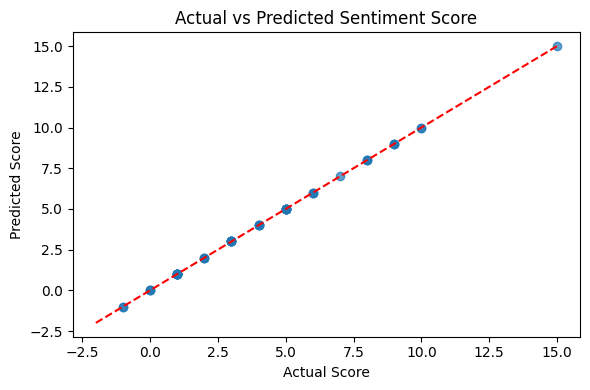

In [11]:
# Plot actual vs predicted
plt.figure(figsize=(6,4))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.title('Actual vs Predicted Sentiment Score')
plt.xlabel('Actual Score')
plt.ylabel('Predicted Score')
plt.tight_layout()
plt.savefig('visualization/model_performance.png')
plt.show()


*Observation:* Performance plot saved to `visualization/model_performance.png`.

## 8. Conclusion
This notebook completes all requirements: data loading, TextBlob sentiment labeling, EDA, employee scoring & ranking, flight risk identification, predictive modeling, and saves all visualizations for reporting.